In [1]:
import numpy as np

from scipy.optimize import minimize
from utils.features import prepare_for_training
from utils.hypothesis import sigmoid

若：一共100个样本，共4个特征，所有样本被分为3类  
则：得到**3个分类器**，参数为一个 **3×4** 矩阵，得到的预测结果是一个100×3的概率矩阵

- np.copy()
- `current_labels = (self.labels == unique_label).astype(float)`
- **scipy**包的详细说明网址：https://docs.scipy.org/doc/scipy/
- 预测，要得到每个对应每个类别的**概率值**
- 维数，保持theta的维数是 **类别数*特征数**
- 而在staticmethod中，theta_ 则是为了方便计算，是**特征数*类别数**
- 如何得到最大概率对应的**索引**
```
class_prediction = np.empty(max_prob_index.shape, dtype=object)
for index, label in enumerate(self.unique_labels):
    class_prediction[max_prob_index == index] = label
```
- `scipy.optimize.minimize`在使用时，传递的`x0`即初始参数，其维度**确保是一维的**；`jac`即梯度函数，也需是一维数组
- 使用NumPy的**高级索引**：利用`np.tile`，并注意使用方法

In [2]:
class logistic_regression:
    def __init__(self, data, labels, polynomial_degree=0, sinusoid_degree=0, normalize_data=False):
        data_processed, features_mean, features_deviation = prepare_for_training(data, polynomial_degree, sinusoid_degree, normalize_data)
        
        self.data = data_processed
        self.labels = labels
        # 类别
        self.unique_labels = np.unique(labels)
        self.features_mean = features_mean
        self.features_deviation = features_deviation
        self.polynomial_degree = polynomial_degree
        self.sinusoid_degree = sinusoid_degree
        self.normalize_data = normalize_data

        num_features = self.data.shape[1]
        num_unique_labels = self.unique_labels.shape[0]
        self.theta = np.zeros((num_unique_labels, num_features)) 

    @staticmethod
    def hypothesis(data, theta_):        
        predictions = sigmoid(np.dot(data, theta_))
        return predictions
    
    @staticmethod
    def cost_function(data, labels, theta_):
        num_examples = data.shape[0]
        predictions = logistic_regression.hypothesis(data, theta_)
        # y_is_1 = labels[labels == 1].T.dot(np.log(predictions[labels == 1]))
        # y_is_0 = (1- labels[labels == 0]).T.dot(np.log(1 - predictions[labels == 0]))
        y_is_set_cost = np.sum(np.log(predictions[labels == 1]))
        y_is_not_set_cost = np.sum(np.log(1 - predictions[labels == 0]))
        cost = (-1 / num_examples) * (y_is_set_cost + y_is_not_set_cost)
        return cost

    @staticmethod
    def gradient_step(data, labels, theta_):
        num_examples = data.shape[0]
        predictions = logistic_regression.hypothesis(data, theta_)
        label_off = predictions - labels
        gradients = (1 / num_examples) * np.dot(data.T, label_off) # 维度: 1*num_features
        return gradients.flatten() ##
          
    @staticmethod
    def gradient_descent(data, labels, initial_theta, max_iter):
        cost_history = []
        num_features = data.shape[1]
        result = minimize(
                    lambda current_theta:logistic_regression.cost_function(data, labels, current_theta.reshape(-1, 1)),
                    # 初始化权重参数
                    initial_theta.flatten(),
                    # 共轭梯度法
                    method = 'CG',
                    # 梯度下计算公式
                    jac = lambda current_theta:logistic_regression.gradient_step(data, labels, current_theta.reshape(num_features, 1)),
                    # 记录结果
                    callback = lambda current_theta:cost_history.append(logistic_regression.cost_function(data, labels, current_theta.reshape(num_features, 1))),
                    options = {'maxiter' : max_iter},
                )
        if not result.success:
            raise ArithmeticError('Can not minimize cost function' + result.message)
        optimized_theta = result.x.reshape(num_features, 1)
        return optimized_theta, cost_history
        
    def train(self, max_iter):
        cost_histories = []
        num_feartures = self.data.shape[1]
        # 有好几个分类器
        for label_index, unique_label in enumerate(self.unique_labels):
            current_initial_theta = np.copy(self.theta[label_index].reshape(-1, 1))
            # 当前类别，就分为两类
            current_labels = (self.labels == unique_label).astype(float)
            current_theta, cost_history = logistic_regression.gradient_descent(self.data, current_labels, current_initial_theta, max_iter)
            self.theta[label_index] = current_theta.T
            cost_histories.append(cost_history)
        return self.theta, cost_histories

    def predict(self, data):
        num_examples = data.shape[0]
        data_processed = prepare_for_training(data, self.polynomial_degree,self.sinusoid_degree, self.normalize_data)[0]
        pro = logistic_regression.hypothesis(data_processed, self.theta.T)
        # 最大值的索引
        max_prob_index = np.argmax(pro, axis=1) 

        #使用的是NumPy的高级索引
        array_label = np.tile(self.unique_labels, (data.shape[0], 1))
        class_prediction = array_label[np.arange(data_processed.shape[0]), max_prob_index]
        
        # class_prediction = np.empty(max_prob_index.shape, dtype=object)
        # for index, label in enumerate(self.unique_labels):
        #     class_prediction[max_prob_index == index] = label
        return class_prediction.reshape(-1, 1)

### Linear Regression
#### 为了修改方便 先在此文件中对鸢尾花数据进行实验

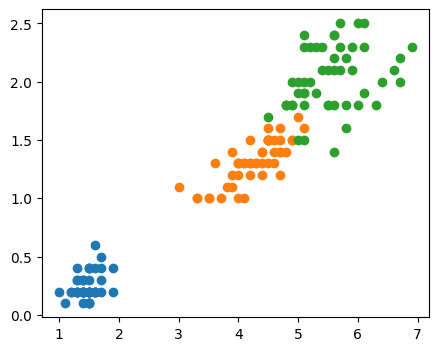

In [3]:
import pandas as pd

import matplotlib.pyplot as plt

data = pd.read_csv('.\data\iris.csv')

iris_types = ['SETOSA', 'VERSICOLOR', 'VIRGINICA']
x_axis = 'petal_length'
y_axis = 'petal_width'

plt.figure(figsize=(5, 4))

for iris_type in iris_types:
    data_ = data[data['class'] == iris_type]
    plt.scatter(data_[x_axis], data_[y_axis], label=iris_type)

plt.show()

- `data[[x_axis, y_axis]]` 对于dataframe
- y_train 必须是**二维数组**，而不是一维数组！！！

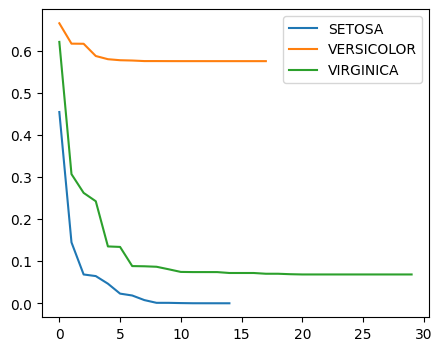

In [4]:
num_examples = data.shape[0]
X_train = data[[x_axis, y_axis]].values #.reshape(-1, 2)
y_train = data['class'].values.reshape(-1, 1)

max_iter = 1000
polynomial_degree=0
sinusoid_degree=0

log_reg = logistic_regression(X_train, y_train, polynomial_degree, sinusoid_degree)
thetas,cost_histories = log_reg.train(max_iter)
labels = log_reg.unique_labels

plt.figure(figsize=(5, 4))

plt.plot(range(len(cost_histories[0])), cost_histories[0], label=labels[0])
plt.plot(range(len(cost_histories[1])), cost_histories[1], label=labels[1])
plt.plot(range(len(cost_histories[2])), cost_histories[2], label=labels[2])
plt.legend()
plt.show()

- X, Y 组合起来一共150*150个结果
- `X_train_ = X_train[(y_train == iris_type).flatten()]`  
**flatten()**变成一维数组(原本是二维数组)，确保布尔索引的形状与X_train的维度匹配
- class中选择的是`normalize_data=False`的原因：标准化后决策边界也是用标准化后的数据画出来的，与原本的数据就不对照了

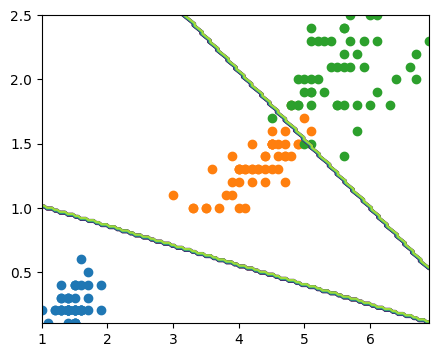

In [5]:
y_train_predict = log_reg.predict(X_train)
# 准确率
precision = np.sum((y_train == y_train_predict)) / y_train.shape[0] * 100

x_min = np.min(X_train[:, 0])
x_max = np.max(X_train[:, 0])
y_min = np.min(X_train[:, 1])
y_max = np.max(X_train[:, 1])

samples = 150
X= np.linspace(x_min, x_max, samples)
Y= np.linspace(y_min, y_max, samples)

Z_SETOSA = np.zeros((samples, samples))
Z_VERSICOLOR = np.zeros((samples, samples))
Z_VIRGINICA = np.zeros((samples, samples))

for x_index, x in enumerate(X):
    for y_index, y in enumerate(Y):
        data = np.array([[x, y]])
        prediction = log_reg.predict(data)
        if prediction == 'SETOSA':
            Z_SETOSA[x_index, y_index] = 1
        elif prediction == 'VERSICOLOR':
            Z_VERSICOLOR[x_index, y_index] = 1
        elif prediction == 'VIRGINICA':
            Z_VIRGINICA[x_index, y_index] = 1

plt.figure(figsize=(5, 4))

for iris_type in iris_types:
    X_train_ = X_train[(y_train == iris_type).flatten()]
    plt.scatter(X_train_[:, 0], X_train_[:, 1], label=iris_type)

plt.contour(X, Y, Z_SETOSA) # 一条线
plt.contour(X, Y, Z_VERSICOLOR) # 两条线
plt.contour(X, Y, Z_VIRGINICA) # 一条线

### Non Linear Boundary

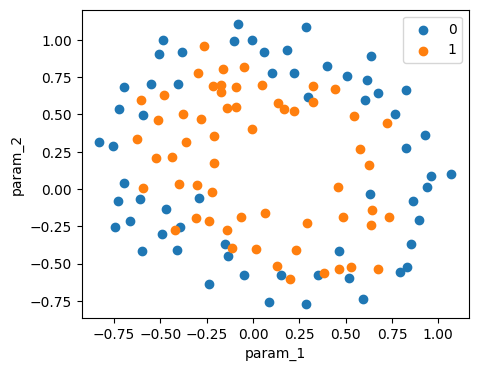

In [6]:
data = pd.read_csv('.\data\microchips-tests.csv')

validities = [0, 1]

x_axis = 'param_1'
y_axis = 'param_2'

plt.figure(figsize=(5,4))
for validity in validities:
    plt.scatter(data[x_axis][data['validity'] == validity], 
                data[y_axis][data['validity'] == validity], 
                label=validity
               )
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.legend()
plt.show()

(118, 1)


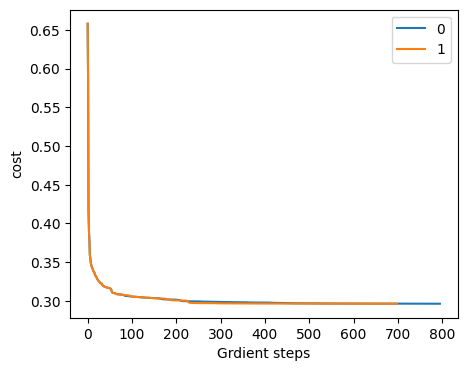

In [9]:
num_examples = data.shape[0]
X_train = data[[x_axis, y_axis]].values.reshape(-1, 2)
y_train = data['validity'].values.reshape(-1, 1)

max_iter = 100000
regularization_param = 0
polynomial_degree = 5
sinusoid_degree = 0

log_reg_ = logistic_regression(X_train, y_train, polynomial_degree, sinusoid_degree, normalize_data=False)

thetas, cost_histories = log_reg_.train(max_iter)

labels = log_reg_.unique_labels

# 画图，关于cost的
plt.figure(figsize=(5, 4))

plt.plot(range(len(cost_histories[0])), cost_histories[0], label=labels[0])
plt.plot(range(len(cost_histories[1])), cost_histories[1], label=labels[1])

plt.xlabel('Grdient steps')
plt.ylabel('cost')
plt.legend()
plt.show()

#### 字母拼错了，耽误半个小时...

In [11]:
y_train_perdict = log_reg_.predict(X_train)

print(X_train.shape)
print(y_train_perdict.shape)

(118, 2)
(118, 1)


一个Z就行了

In [21]:
y_train_predict = log_reg_.predict(X_train)

print(y_train.shape)
print(y_train_predict.shape)

# 准确率
precision_ = np.sum(y_train_predict == y_train) / X_train.shape[0] * 100
print(precision_)

sample_num = 150
x_max = np.max(X_train[:, 0])
x_min = np.min(X_train[:, 0])
y_max = np.max(X_train[:, 1])
y_min = np.min(X_train[:, 1])
X = np.linspace(x_min, x_max, sample_num)
Y = np.linspace(y_min, y_max, sample_num)


Z = np.zeros((sample_num, sample_num))

for x_label, x in enumerate(X):
    for y_label, y in enumerate(Y):
        data = np.array([[x, y]])
        Z[x_label, y_label] = log_reg_.predict(data)[0][0]

(118, 1)
(118, 1)
88.98305084745762


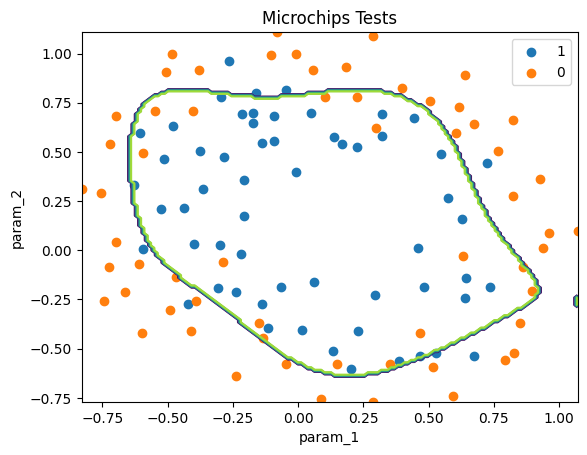

In [22]:
# 变成 一维 布尔数组
postives = (y_train == 1).flatten()
negtives = (y_train == 0).flatten()

plt.scatter(X_train[postives, 0], X_train[postives, 1], label='1')
plt.scatter(X_train[negtives, 0], X_train[negtives, 1], label='0')

plt.contour(X, Y, Z)

plt.xlabel('param_1')
plt.ylabel('param_2')
plt.title('Microchips Tests')
plt.legend()
plt.show()   